In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping

# Load the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1.0
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

# Generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='tanh', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    return model

# Discriminator model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=img_shape, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# Build and compile the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# Hyperparameters
latent_dim = 100
img_shape = (28, 28, 1)

# Build the generator, discriminator, and GAN models
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)
gan = build_gan(generator, discriminator)

# Training parameters
epochs = 10000
batch_size = 64

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training loop
for epoch in range(epochs):
    # Generate a random noise for the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)

    # Select a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Labels for generated and real data
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Train the discriminator on real and generated data
    d_loss_real = discriminator.train_on_batch(real_images, valid)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator to fool the discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress and save generated images at specified intervals
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

    # Early stopping
    if epoch > 500 and epoch % 100 == 0:
        if g_loss < 0.2:
            print("Early stopping as the generator has achieved low loss.")
            break

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
5100 [D loss: 0.6326056122779846] [G loss: 1.362808108329773]
2/2 [==============================] - 0s 5ms/step
5200 [D loss: 0.4854411780834198] [G loss: 1.3992770910263062]
2/2 [==============================] - 0s 6ms/step
5300 [D loss: 0.5769940614700317] [G loss: 1.6117502450942993]
2/2 [==============================] - 0s 6ms/step
5400 [D loss: 0.5286420434713364] [G loss: 1.3844354152679443]
2/2 [==============================] - 0s 6ms/step
5500 [D loss: 0.5576276183128357] [G loss: 1.5343374013900757]
2/2 [==============================] - 0s 5ms/step
5600 [D loss: 0.5607843697071075] [G loss: 1.569101095199585]
2/2 [==============================] - 0s 6ms/step
5700 [D loss: 0.576677531003952] [G loss: 1.5714080333709717]
2/2 [==============================] - 0s 5ms/step
5800 [D loss: 0.5850735008716583] [G loss: 1.6365070343017578]
2/2 [==============================] - 0

1/1 [==============================] - 0s 19ms/step


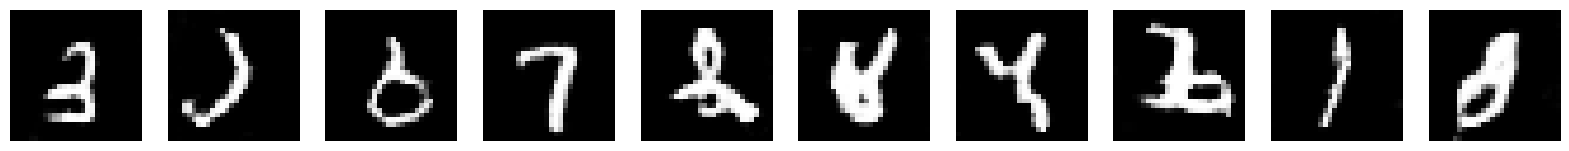

In [ ]:
def generate_output(generator, epoch, latent_dim):
    noise = np.random.normal(0, 1, (10, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()

generate_output(generator, epochs, latent_dim)